# Analysis on correlation between earthquakes and surface mass loading in individual mascons

In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# from global_land_mask import globe
import scipy.stats as stats
import os
import importlib
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm
import numpy.ma as ma
from tqdm import tqdm
from shapely.geometry import Point, Polygon

# file containing functions:
import loadquakes
importlib.reload(loadquakes)

<module 'loadquakes' from '/Users/amandasyamsul/SLIQ/loadquakes.py'>

## 1. Load datasets

- GRACE and GRACE-FO
- USGS earthquake catalog with ETAS probabilities

In [2]:
# GRACE data
ds = xr.open_dataset("GRCTellus.JPL.200204_202201.GLO.RL06M.MSCNv02CRI.nc")

# Catalog of events from 2002-04-16 to 2022-1-16 with magnitude >= 5.4
catalog = pd.read_csv('ind_and_bg_probs.csv')
catalog["time"] = catalog["time"].astype("datetime64[ns]")

In [3]:
# This is the catalog with all details from the USGS Earthquake Catalog

original_catalog = pd.read_csv('19970101-20220116.csv')
original_catalog = original_catalog[original_catalog['time']>'2002-04-16']
original_catalog = original_catalog[original_catalog['time']<'2022-01-16']
cat = original_catalog.reset_index()

depth = cat['depth']
catalog['depth'] = depth

## 2. Using Mizrahi's ETAS code, filter events that that have less than 90% chance of being triggered
##### The mean probability of being triggered (P_triggered) for the catalog is 97.97% with a standard deviation of 9.25% . Here, we examine events that have less 90% probability of being triggered by another earthquake

In [4]:
etas_declustered = catalog[catalog['P_triggered']<.9]

## 3. Add surface load data to the earthquake dataframes

In [5]:
etas_declustered = pd.read_csv('etas_declustered.csv')
catalog = pd.read_csv('catalog.csv')

## 4. Analyze correlation between all events and surface mass loading by mascon

###  This method calculates LgE and L using mascons from the JPL mascon placement file

In [6]:
'''
Calculates conditional probability P(E|L) using loads during earthquakes (LgE) and loads during all time periods (L)

'''

def get_cp(LgE, L):
    cp_list = []  
    
    bins = np.linspace(-40,40,40)

    LgE_hist = np.histogram(LgE, bins=bins, density=True)[0] 
    L_hist = np.histogram(L, bins=bins, density=True)[0]

    cp = np.divide(LgE_hist, L_hist, out=np.zeros_like(LgE_hist), where=L_hist != 0)

    return bins, cp  #  list of cps for all mascons that contain earthquakes

In [7]:
def calc_circle_cp_by_mascon(catalog, L_override=None):
    """
    Calculates conditional probability P(E|L) in every mascon using each mascon's center coordinates 
    and creating a 1.5 degree radius spherical cap around each one.
    If L_override is provided, it replaces the calculated L.
    """

    # Convert catalog to GeoDataFrame
    geometry = [Point(xy) for xy in zip(catalog['longitude'], catalog['latitude'])]
    catalog_gdf = gpd.GeoDataFrame(catalog, geometry=geometry, crs="EPSG:4326")  # Handle the earthquakes by "mascon"
    
    mascon = xr.open_dataset('JPL_MSCNv03_PLACEMENT.nc')

    lwe_data = ds['lwe_thickness']

    mascon_center_lat = mascon['mascon_lat'].data
    mascon_center_lon = mascon['mascon_lon'].data
    mascon_id = mascon['mascon_id'].data
    cap_radius_deg = 1.5  # Spherical cap radius in degrees

    cp = []

    # Create spatial index for catalog_gdf to optimize spatial joins
    catalog_gdf.sindex

    # Iterate through each mascon center
    # for i in tqdm(range(len(mascon_id)), miniters=500):
    for i in range(len(mascon_id)):
        # Create a Point for the mascon center
        center_point = Point(mascon_center_lon[i], mascon_center_lat[i])

        # Define a circular buffer (spherical cap) with a 1.5-degree radius
        bbox = center_point.buffer(cap_radius_deg)

        # Convert the buffer to a GeoDataFrame for spatial operations
        bbox_gdf = gpd.GeoDataFrame([1], geometry=[bbox], crs="EPSG:4326")

        # Spatial join to find earthquakes within the spherical cap
        these_earthquakes = gpd.sjoin(catalog_gdf, bbox_gdf, how='inner', predicate='within')

        # Skip to the next iteration if no earthquakes are found within this cap
        if these_earthquakes.empty:
            continue

        # Retrieve load data for this mascon using the center coordinates
        these_loads = lwe_data.sel(lat=mascon_center_lat[i], lon=mascon_center_lon[i], method="nearest").data.flatten()

        # Determine the value of L to use
        if L_override is not None:
            L = L_override  # Use provided L_override
        else:
            L = these_loads  # Use internally calculated L

        # Calculate conditional probabilities
        nt = 205  # per month
        ng = (1 - np.cos(cap_radius_deg * np.pi / 180)) / 2 * 510e6 / 1e5  # area per 100k square km
        LgE = these_earthquakes.dmass
        L = these_loads
        E = len(these_earthquakes) / nt / ng

        # Compute P(E|L)
        circle_bins, this_cp = get_cp(LgE, L)
        this_cp = this_cp * E
        cp.append(this_cp)

    # Average conditional probabilities across all mascons
    circle_cp_averaged = np.nanmean(np.array(cp), axis=0)
    
    return circle_cp_averaged, circle_bins

In [8]:
circle_cp_averaged, circle_bins = calc_circle_cp_by_mascon(catalog, L_override=None)

/Applications/anaconda3/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/Applications/anaconda3/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


40
39


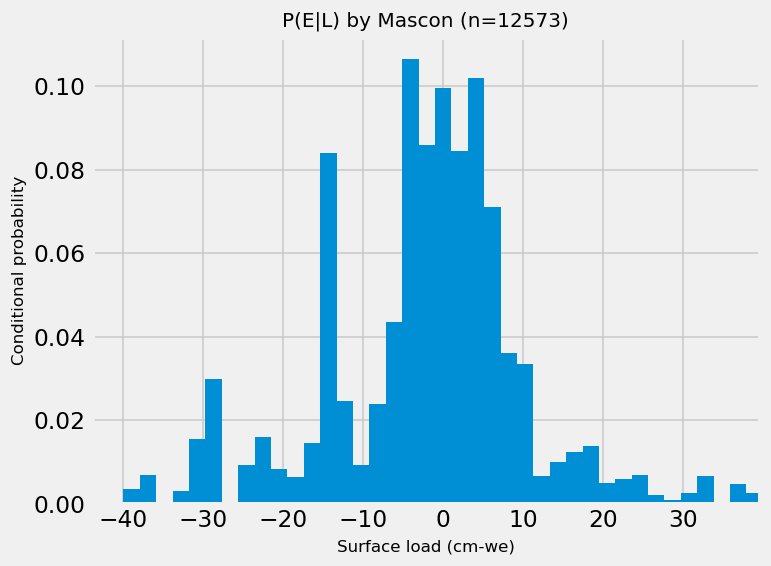

In [9]:
# Plot the averaged conditional probabilities
plt.style.use('fivethirtyeight')

wid = np.mean(np.diff(circle_bins))

print(len(circle_bins))
print(len(circle_cp_averaged))

# Create a figure and axis instance
fig, ax = plt.subplots(dpi=120)

# Plot the bar chart
norm_cp_avg = circle_cp_averaged / ( (1 - np.cos((3 * np.pi / 180) / 2)) / 2 * 4551)
ax.bar(circle_bins[:-1], norm_cp_avg, width=wid, align='edge')

# Set font size
fs = 10

# Set axis limits and labels
xl = ax.get_xlim()
ax.set_xlim(xl[0], xl[1] - 4.4)
ax.set_xlabel('Surface load (cm-we)', fontsize=fs)
ax.set_ylabel('Conditional probability', fontsize=fs)
ax.set_title('P(E|L) by Mascon (n=12573)', fontsize=fs+2)

# Enable grid
ax.grid(True)

# Show the plot
plt.show()

In [10]:
# '''
# Sanity Check!
# '''
# base = bbox_gdf.boundary.plot(color='red', linewidth=2)
# catalog_gdf.plot(ax=base, marker='o', color='blue', markersize=5, label='All Earthquakes')
# # these_earthquakes.plot(ax=base, marker='o', color='red', markersize=5, label='Selected Earthquakes')
# plt.xlim([-2,2])
# plt.ylim([-88,-92])
# plt.legend()
# plt.show()

## 5. Significance testing

### The code below does the following:
1. Scramble loads (ds.lwe_thickness) and generate randomized data
2. Calculate cp for each randomized load dataset

In [11]:
# Flatten the surface load dataset to scramble
all_grace_data = np.array(ds.lwe_thickness).flatten()
rng = np.random.default_rng()  # Random number generator

cp_real_distribution = []
N = 50  # Number of randomizations

# Scramble and calculate cp for each randomization
for i in tqdm(range(N)):
    scrambled_data = rng.permutation(all_grace_data)
    circle_cp_averaged, circle_bins = calc_circle_cp_by_mascon(catalog, L_override=scrambled_data)
    cp_real_distribution.extend(circle_cp_averaged)

cp_real_distribution = np.array(cp_real_distribution)

  0%|                                                      | 0/50 [00:00<?, ?it/s]/Applications/anaconda3/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/Applications/anaconda3/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
  2%|▉                                             | 1/50 [00:34<27:58, 34.26s/it]/Applications/anaconda3/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/Applications/anaconda3/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
  4%|█▊                                            | 2/50 [01:08<27:24, 34.26s/it]/Applications/anaconda3/lib/python3.11/site-packages/numpy/lib/histograms.py:883: Runt

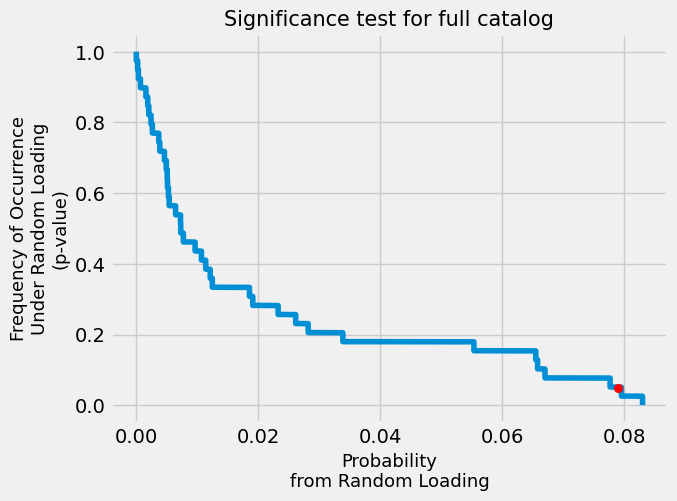

In [12]:
# Visualization of significance testing
fs=13
sorted_data = np.sort(cp_real_distribution)
plt.plot(sorted_data, 1 - np.arange(sorted_data.size) / sorted_data.size)
plt.scatter(0.079, 0.05, c='r', zorder=29)
plt.ylabel('Frequency of Occurrence\nUnder Random Loading\n(p-value)', fontsize=fs)
plt.xlabel('Probability\nfrom Random Loading', fontsize=fs)
plt.title('Significance test for full catalog', fontsize=fs+2)
plt.show()

###  Repeating analysis for ETAS declustered catalog

/Applications/anaconda3/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


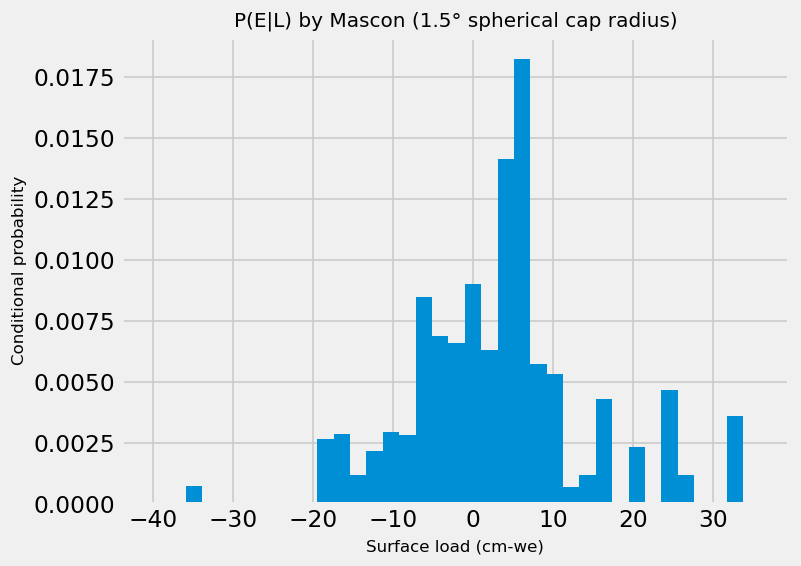

In [13]:
etas_circle_cp_averaged, etas_circle_bins = calc_circle_cp_by_mascon(etas_declustered, L_override=None)

# Plot the averaged conditional probabilities
plt.style.use('fivethirtyeight')

wid = np.mean(np.diff(etas_circle_bins))

# Create a figure and axis instance
fig, ax = plt.subplots(dpi=120)

# Plot the bar chart
norm_cp_avg = etas_circle_cp_averaged / ( (1 - np.cos((3 * np.pi / 180) / 2)) / 2 * 4551)
ax.bar(circle_bins[:-1], norm_cp_avg, width=wid, align='edge')

# Set font size
fs = 10

# Set axis limits and labels
xl = ax.get_xlim()
ax.set_xlim(xl[0], xl[1] - 4.4)
ax.set_xlabel('Surface load (cm-we)', fontsize=fs)
ax.set_ylabel('Conditional probability', fontsize=fs)
ax.set_title('P(E|L) by Mascon (1.5\N{DEGREE SIGN} spherical cap radius)', fontsize=fs+2)

# Enable grid
ax.grid(True)

# Show the plot
plt.show()

In [14]:
# Flatten the surface load dataset to scramble
all_grace_data = np.array(ds.lwe_thickness).flatten()
rng = np.random.default_rng()  # Random number generator

etas_cp_real_distribution = []
N = 50  # Number of randomizations

# Scramble and calculate cp for each randomization
for i in tqdm(range(N)):
    scrambled_data = rng.permutation(all_grace_data)
    etas_circle_cp_averaged, etas_circle_bins = calc_circle_cp_by_mascon(etas_declustered, L_override=scrambled_data)
    etas_cp_real_distribution.extend(etas_circle_cp_averaged)

etas_cp_real_distribution = np.array(etas_cp_real_distribution)

  0%|                                                      | 0/50 [00:00<?, ?it/s]/Applications/anaconda3/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
  2%|▉                                             | 1/50 [00:20<17:03, 20.89s/it]/Applications/anaconda3/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
  4%|█▊                                            | 2/50 [00:42<16:56, 21.18s/it]/Applications/anaconda3/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
  6%|██▊                                           | 3/50 [01:04<16:51, 21.53s/it]/Applications/anaconda3/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
  8%

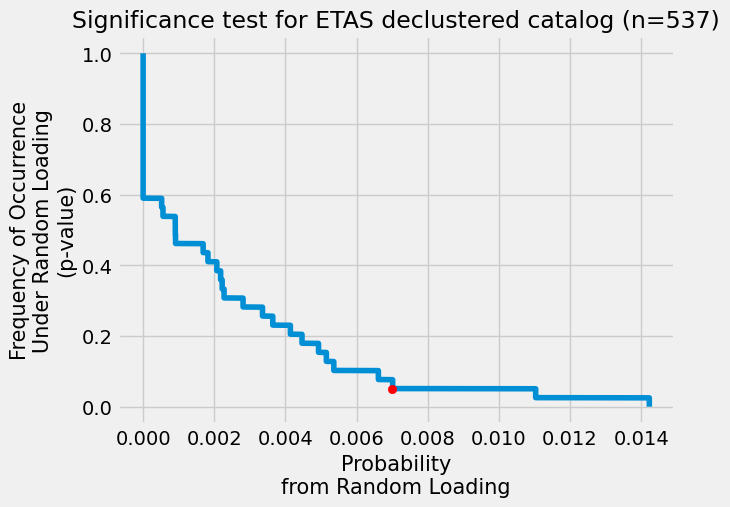

In [15]:
# Visualization of significance testing
fs=15
sorted_data = np.sort(etas_cp_real_distribution)
plt.plot(sorted_data, 1 - np.arange(sorted_data.size) / sorted_data.size)
plt.scatter(0.007, 0.05, c='r', zorder=29)
plt.ylabel('Frequency of Occurrence\nUnder Random Loading\n(p-value)', fontsize=fs)
plt.xlabel('Probability\nfrom Random Loading', fontsize=fs)
plt.title('Significance test for ETAS declustered catalog (n=537)', fontsize=fs+2)
plt.show()